In [1]:
path="D:/work/mining/archive/INvideos.csv"

### Trending YouTube Video Statistics
- using indian dataset to predict the viewer count [https://www.kaggle.com/datasets/datasnaek/youtube-new]

### Table of content
- An attempt is made to fit a model to predict the amount of views of a trending video as a function of its amount of likes, dislikes, comments, and other factors.
- According to the model the statistically significant factors are the amount of likes, dislikes, whether the ratings and/or comments were disabled, and if the video was uploaded in the weekend.
- The model does not provide enough evidence that the amount of comments is significant.

In [2]:
#Make Necessary Import
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.21.6
pandas version :  1.3.5
seaborn version :  0.12.2


### Data Loading and preperation

In [3]:
data = pd.read_csv(path)
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


In [4]:
print("Features that are used in the dataset are: ")
for id,col in enumerate(data.columns,start=1):
    print(f"{id}. {col.capitalize()}")

Features that are used in the dataset are: 
1. Video_id
2. Trending_date
3. Title
4. Channel_title
5. Category_id
6. Publish_time
7. Tags
8. Views
9. Likes
10. Dislikes
11. Comment_count
12. Thumbnail_link
13. Comments_disabled
14. Ratings_disabled
15. Video_error_or_removed
16. Description


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                37352 non-null  object
 1   trending_date           37352 non-null  object
 2   title                   37352 non-null  object
 3   channel_title           37352 non-null  object
 4   category_id             37352 non-null  int64 
 5   publish_time            37352 non-null  object
 6   tags                    37352 non-null  object
 7   views                   37352 non-null  int64 
 8   likes                   37352 non-null  int64 
 9   dislikes                37352 non-null  int64 
 10  comment_count           37352 non-null  int64 
 11  thumbnail_link          37352 non-null  object
 12  comments_disabled       37352 non-null  bool  
 13  ratings_disabled        37352 non-null  bool  
 14  video_error_or_removed  37352 non-null  bool  
 15  de

### <span style="color: red;">Findings:</span>
- Dataframe have 18 columns
- Dataframe have 37352 rows
- Total categorical columns are 8 columns
- Total numerical columns are 8 columns
- `views` column is the target for this dataset

### Removing Nulls and duplicates

In [6]:
print("{:>22}: {}\n".format("amount of entries", data['video_id'].count()))
for key in data.keys():
    print("{:>22}: {} missing values".format(key, data[key].isna().sum()))

     amount of entries: 37352

              video_id: 0 missing values
         trending_date: 0 missing values
                 title: 0 missing values
         channel_title: 0 missing values
           category_id: 0 missing values
          publish_time: 0 missing values
                  tags: 0 missing values
                 views: 0 missing values
                 likes: 0 missing values
              dislikes: 0 missing values
         comment_count: 0 missing values
        thumbnail_link: 0 missing values
     comments_disabled: 0 missing values
      ratings_disabled: 0 missing values
video_error_or_removed: 0 missing values
           description: 561 missing values


In [7]:
# We are just droping the the rows which has no description
# removing duplicates on basis of video_id
# removing all the rows in which video has some error in uploading
data = data.dropna()
data.drop_duplicates(subset = ['video_id'], keep = 'last', inplace = True)
print("amount of videos after removing duplicates:", data['video_id'].count())
data = data[data['video_error_or_removed'] == False]
print("amount of videos after removing deleted entries:", data['video_id'].count())

amount of videos after removing duplicates: 16021
amount of videos after removing deleted entries: 16020


### <span style="color: red;">Findings:</span>
- No column have any missing data except one that is `discription`
- After removing the null entries rows, we are left with `36791` rows
- After removing all the duplicates values in `video_id`, we are left with `16021` rows

In [8]:
# Adding few more columns to the dataset
data["No_tags"] = [len(i) for i in data["tags"]]
data["desc_len"] = [len(i) if isinstance(i, str) else 0 for i in data["description"]]
data["len_title"] = [len(i) for i in data["title"]]

In [9]:
# Separation of Categorical and Numerical Data
cats = ['trending_date','title','channel_title','publish_time','tags','comments_disabled','ratings_disabled',
       'description']
nums = ['category_id','views','likes','dislikes','comment_count','No_tags','desc_len','len_title']

### Statistical Numerical Data

In [10]:
data[nums].describe()

,category_id,views,likes,dislikes,comment_count,No_tags,desc_len,len_title
count,16020.000000,1.602000e+04,1.602000e+04,1.602000e+04,16020.000000,16020.000000,16020.000000,16020.000000
mean,22.381648,6.903868e+05,1.464621e+04,9.691783e+02,1504.113358,323.231024,906.182647,70.793820
std,5.962514,2.382313e+06,6.743429e+04,1.275536e+04,10499.810485,158.863561,798.278664,21.708705
min,1.000000,4.024000e+03,0.000000e+00,0.000000e+00,0.000000,3.000000,3.000000,5.000000
25%,23.000000,8.972925e+04,5.677500e+02,7.000000e+01,47.000000,183.000000,364.000000,54.000000
50%,24.000000,2.075125e+05,1.776000e+03,1.960000e+02,198.000000,357.000000,672.000000,74.000000
75%,25.000000,5.343982e+05,6.579000e+03,5.980000e+02,714.000000,476.000000,1226.000000,90.000000
max,43.000000,1.254322e+08,2.912710e+06,1.545017e+06,807558.000000,629.000000,5135.000000,100.000000


### Graphical Analysis

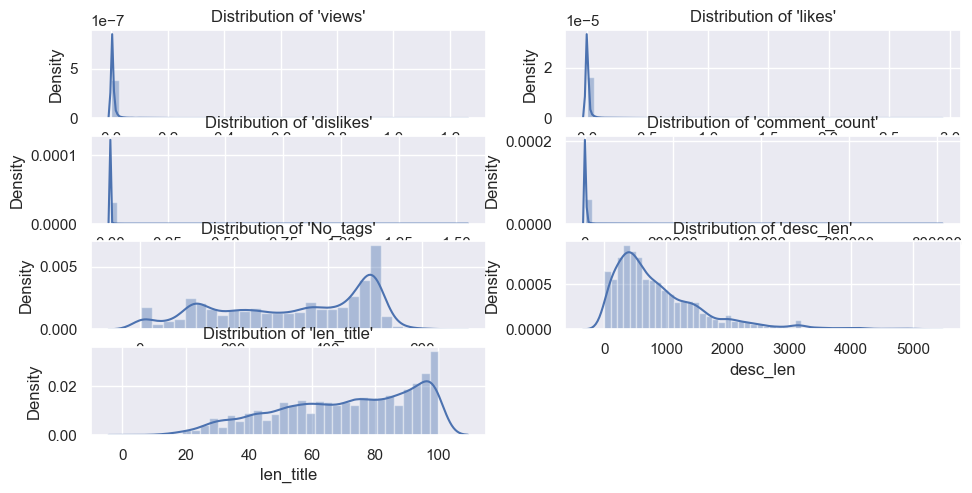

In [48]:
# Plotting the distributions of the variables:
fig, plots = plt.subplots(4,2, figsize = (10,5))
plots = plots.flatten()
labels = ['views', 'likes', 'dislikes', 'comment_count','No_tags','desc_len','len_title']
for i in range(len(labels)):
    plots[i] = sns.distplot(data[labels[i]], ax = plots[i])
    plots[i].set_title("Distribution of '{}'".format(labels[i]))
fig.delaxes(plots[-1])

In [12]:
data['views_log'] = np.log(data['views'])
data['likes_log'] = np.log(data['likes'] + 1)
data['dislikes_log'] = np.log(data['dislikes'] + 1)
data['comment_count_log'] = np.log(data['comment_count'] + 1)

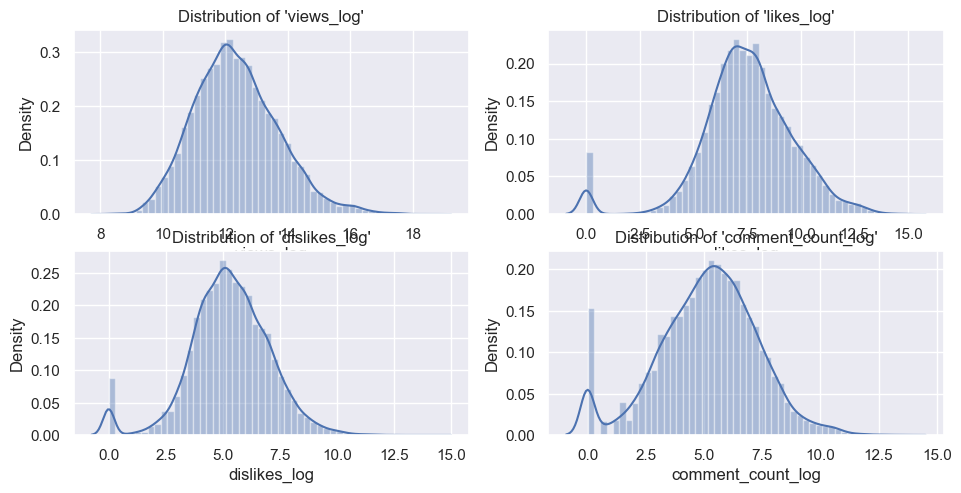

In [49]:
# Ploting them again:
fig, plots = plt.subplots(2,2, figsize = (10,5))
plots = plots.flatten()
labels = ['views_log', 'likes_log', 'dislikes_log', 'comment_count_log']
for i in range(len(labels)):
    plots[i] = sns.distplot(data[labels[i]], ax = plots[i])
    plots[i].set_title("Distribution of '{}'".format(labels[i]))

### <span style="color: red;">Findings:</span>
- Some data variables are heavily skwed
- So we may need to perform Log() transformation
- Entries where values are `0` we will add `1` before Log() transformation so that there is no domain error and value still remains `0`

### Statistical Categorical Data

In [14]:
data[cats].describe()

,trending_date,title,channel_title,publish_time,tags,comments_disabled,ratings_disabled,description
count,16020,16020,16020,16020,16020,16020,16020,16020
unique,204,15963,1385,15839,12030,2,2,13084
top,18.14.03,Kasthooriman || General Promo || Mon to Sat at...,Study IQ education,2018-01-17T15:00:02.000Z,[none],False,False,Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...
freq,143,6,169,3,551,15442,15626,101


### <span style="color: red;">Findings:</span>
- Data in `trending_date` has `204` unique values
- Data in `title` has `15963` unique values
- Data in `channel_title` has `1385` unique values
- Data in `publish_time` has `15839` unique values
- Data in `tags` has `12030` unique values
- Data in `comments_disabled` has `2` unique values with majority is False value
- Data in `ratings_disabled` has `2` unique values with majority is False value
- Data in `description` has `13084` unique values

## Hypothesis
---
We are assuming that the following variables can be used to predict the numbers of views of a youtube video
- The amount of likes on a video (discrete)
- The amount of dislikes on a video (discrete)
- The amount of user comments on a video (discrete)
- The amount of user tags on a video (discrete)
- Whether the video's rating functionalities were disabled by the creator (categorical: 0, 1)
- Whether the video's comment functionalities were disabled (categorical: 0, 1)
---
### General Hypothesis
- $H_0$ : The view count of trending videos cannot be predicted by `likes`, `dislikes`, `comment count`, `comments disabled`, `ratings disabled`, `No_tags`.
- $H_a$ : The view count of trending videos can be predicted by `likes`, `dislikes`, `comment count`, `comments disabled`, `ratings disabled`, `No_tags`.


### Target Variable

In [15]:
data['views_log'].describe()

count    16020.000000
mean        12.347520
std          1.337339
min          8.300032
25%         11.404552
50%         12.242947
75%         13.188897
max         18.647276
Name: views_log, dtype: float64

### Exlanatory Variables

In [16]:
exp_var=["likes_log","dislikes_log","comment_count_log","comments_disabled","ratings_disabled", "No_tags"]

In [17]:
for var in exp_var:
    print(data[var].describe(),end="\n\n")

count    16020.000000
mean         7.501270
std          2.163594
min          0.000000
25%          6.343441
50%          7.482682
75%          8.791790
max         14.884595
Name: likes_log, dtype: float64

count    16020.000000
mean         5.293961
std          1.736501
min          0.000000
25%          4.262680
50%          5.283204
75%          6.395262
max         14.250546
Name: dislikes_log, dtype: float64

count    16020.000000
mean         5.171470
std          2.128794
min          0.000000
25%          3.871201
50%          5.293305
75%          6.572283
max         13.601771
Name: comment_count_log, dtype: float64

count     16020
unique        2
top       False
freq      15442
Name: comments_disabled, dtype: object

count     16020
unique        2
top       False
freq      15626
Name: ratings_disabled, dtype: object

count    16020.000000
mean       323.231024
std        158.863561
min          3.000000
25%        183.000000
50%        357.000000
75%        476.000000
m

## More Graphical Analysis
- ### Univariate Analysis

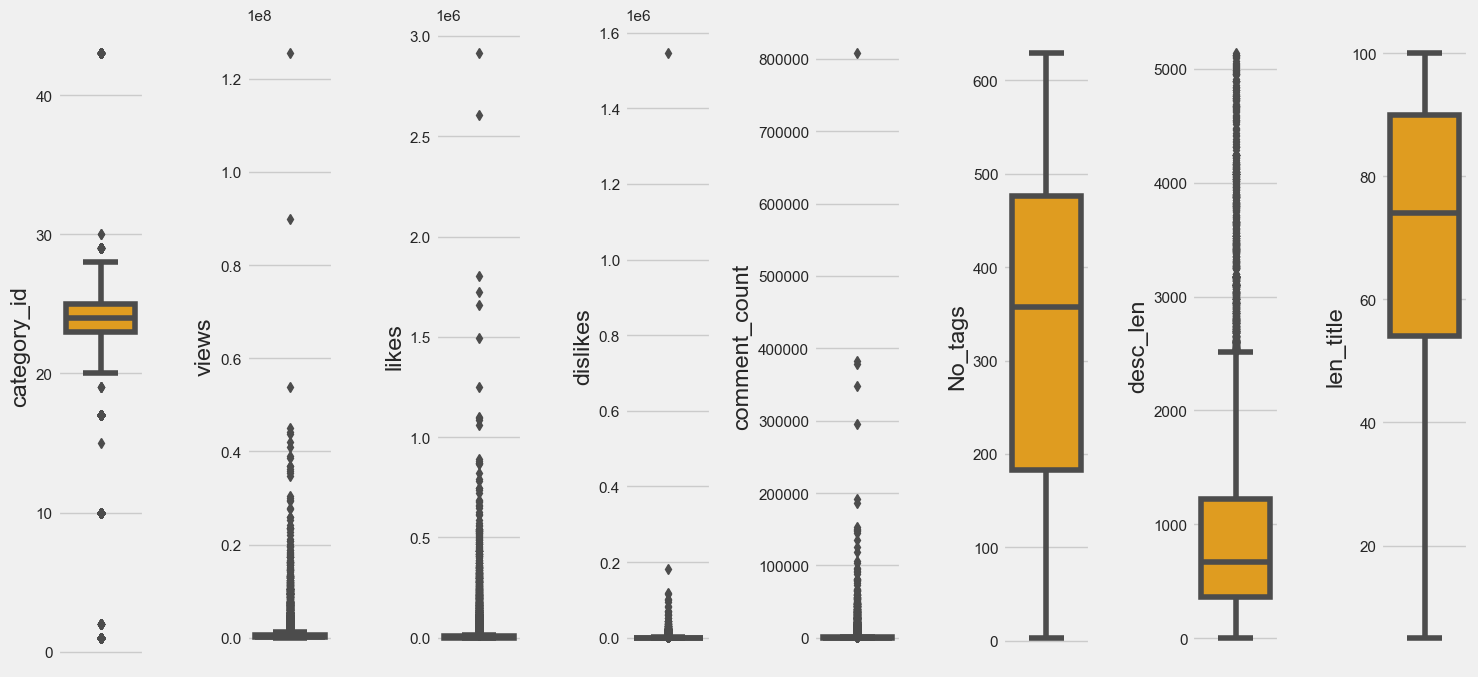

In [18]:
# look at the distribution of data with boxplot
features = ['category_id','views','likes','dislikes','comment_count','No_tags','desc_len','len_title']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=data[features[i]],color='orange',orient='v')
    plt.tight_layout();
#plt.savefig('fig/boxplot.png')

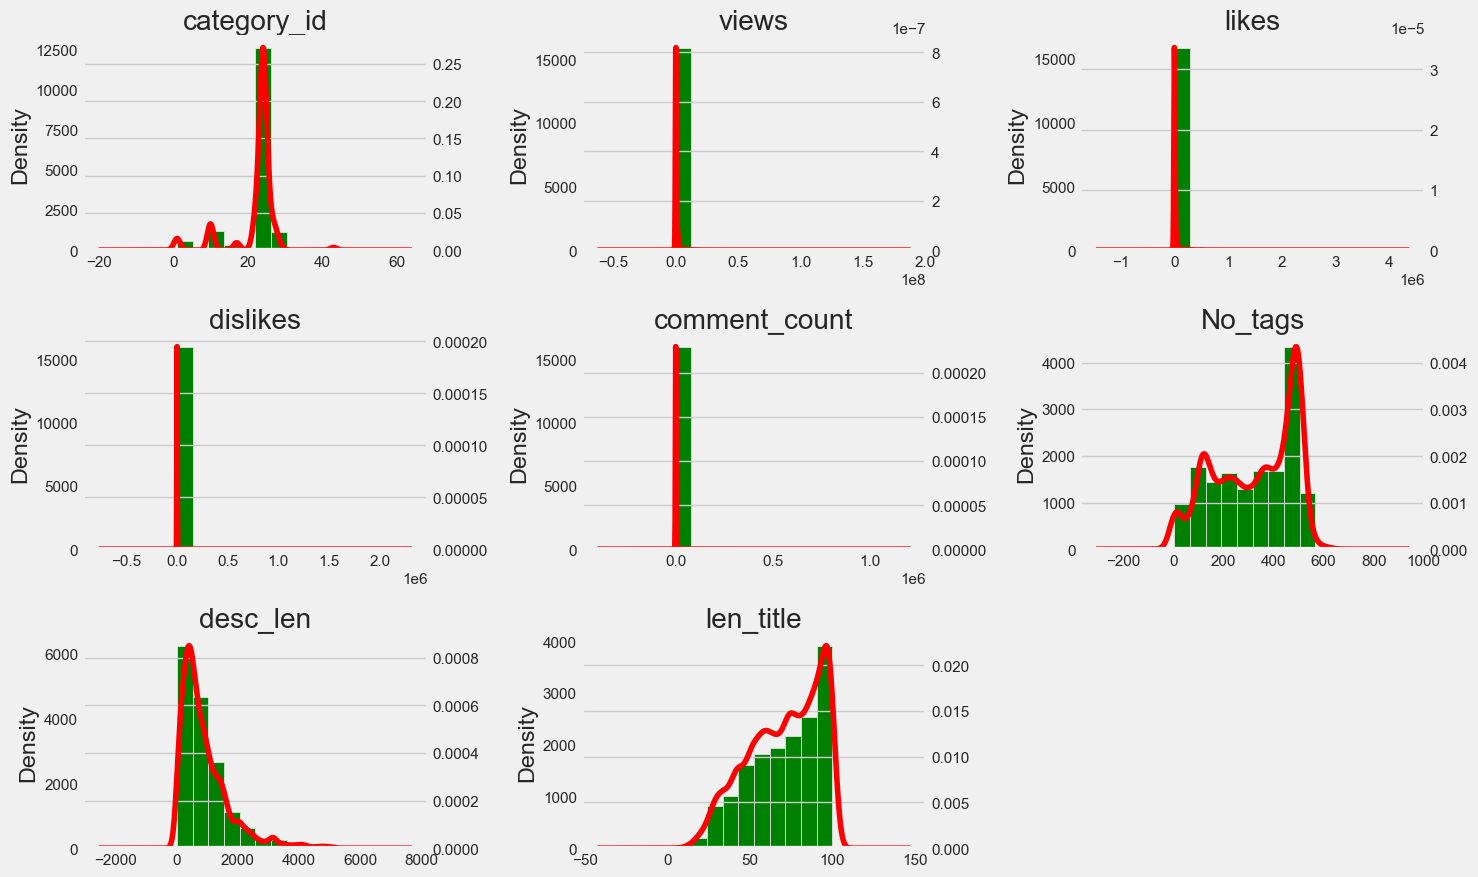

In [19]:
#View data distribution
data_num = data[features]
k = len(data_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(data_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax, color='green')
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='red')
    ax2.set_ylim(0)
fig.delaxes(axes[2,2])
fig.tight_layout()
#plt.savefig('fig/distribusi data.png')

### <span style="color: red;">Findings:</span>
- It is clear from `graph` that we have heavily skewed numerical data for `view`, `likes`, `dislikes`, `comment_count`
- It can also be seen from `Boxplot` that the `view`, `likes`, `dislikes`, `comment_count`, `No_tags`, and `desc_len` features have many outliers
- Hence Logarithmic Tranformation was necessary

### Bivariate Analysis

<Figure size 1000x800 with 0 Axes>

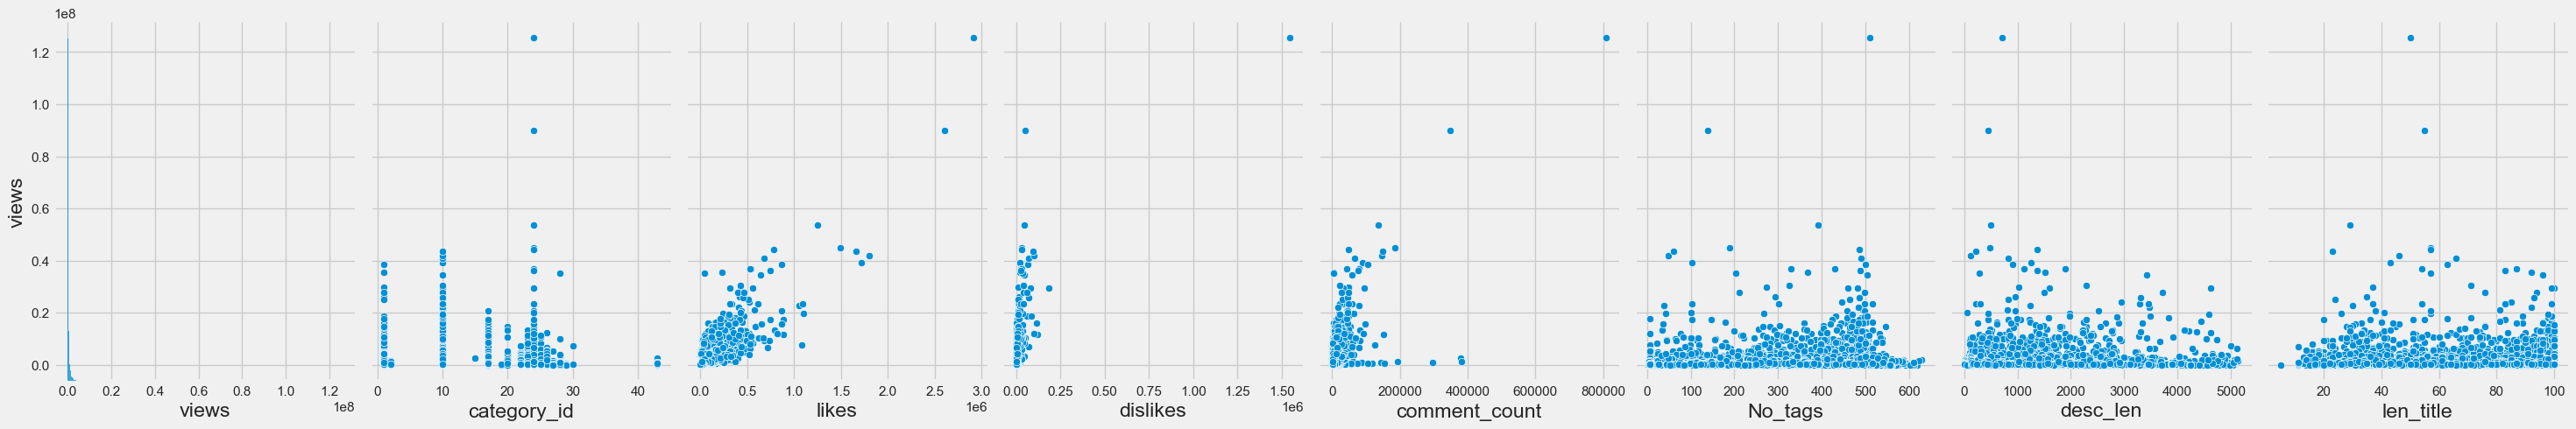

In [20]:
#create a pairplot graph from each numeric data
plt.figure(figsize=(10,8))
sns.pairplot(data=data, x_vars=['views','category_id','likes','dislikes','comment_count','No_tags','desc_len','len_title'], y_vars=['views'], height=5, aspect=0.75);
fig.tight_layout();
#plt.savefig('fig/pairplot.png')

### Multivariate Analysis

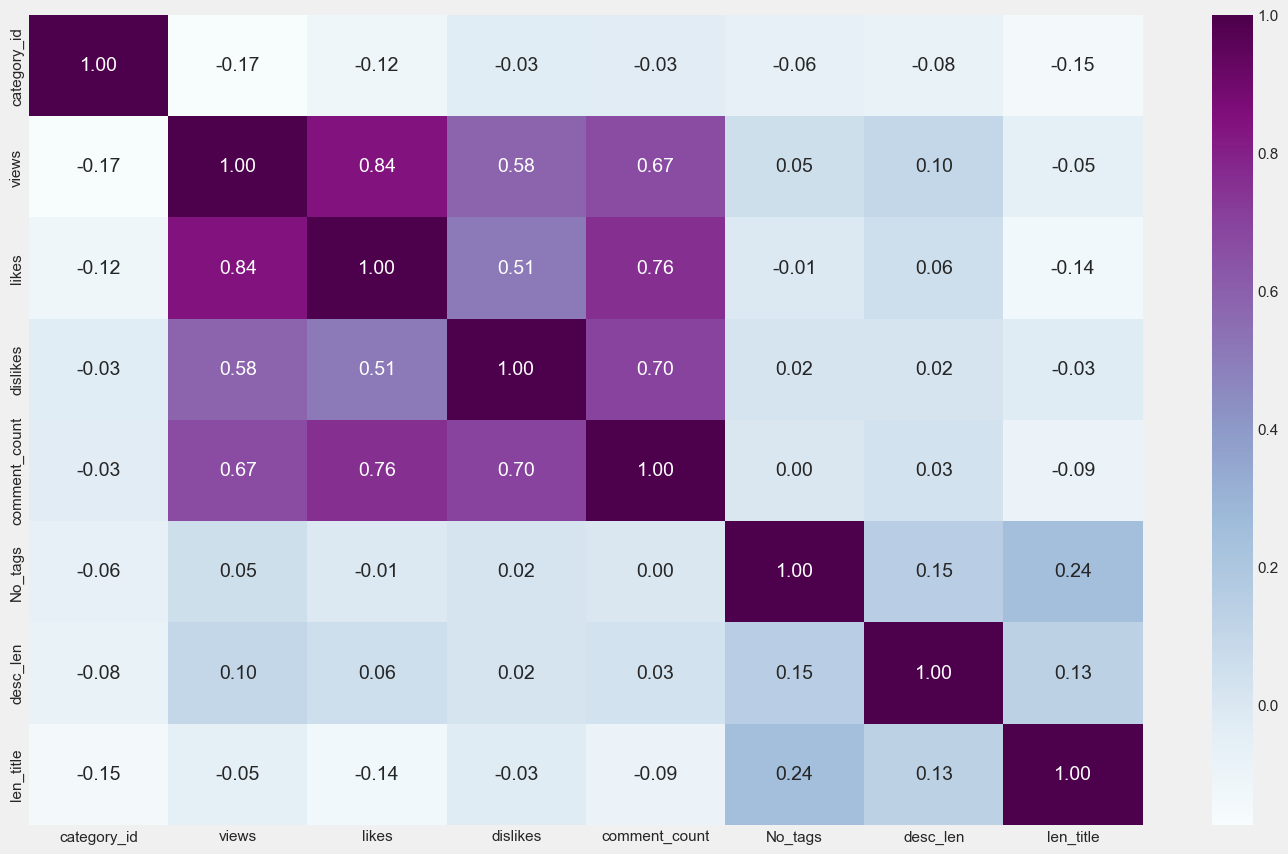

In [21]:
#create a correlation matrix from each numeric data
features = ['category_id','views','likes','dislikes','comment_count','No_tags','desc_len','len_title']
corr_= data[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu");
#plt.savefig('fig/heatmap.png');

### <span style="color: red;">Findings:</span>
- Some Co-relations can be seen between `Views`, `likes`, `dislikes`, `comment_count`

# Data Preparation

In [22]:
exp_var_num=["likes_log","dislikes_log","comment_count_log", "No_tags","views_log"]

In [23]:
data_clean=data[exp_var_num]

In [24]:
data_clean.describe()

,likes_log,dislikes_log,comment_count_log,No_tags,views_log
count,16020.000000,16020.000000,16020.000000,16020.000000,16020.000000
mean,7.501270,5.293961,5.171470,323.231024,12.347520
std,2.163594,1.736501,2.128794,158.863561,1.337339
min,0.000000,0.000000,0.000000,3.000000,8.300032
25%,6.343441,4.262680,3.871201,183.000000,11.404552
50%,7.482682,5.283204,5.293305,357.000000,12.242947
75%,8.791790,6.395262,6.572283,476.000000,13.188897
max,14.884595,14.250546,13.601771,629.000000,18.647276


In [25]:
for var in exp_var_num:
    data_clean["std_"+var]= MinMaxScaler().fit_transform(data_clean[var].values.reshape(len(data_clean), 1))

In [26]:
data_clean.head()

,likes_log,dislikes_log,comment_count_log,No_tags,views_log,std_likes_log,std_dislikes_log,std_comment_count_log,std_No_tags,std_views_log
12,6.575076,3.988984,0.000000,494,11.958156,0.441737,0.279918,0.000000,0.784345,0.353536
22,7.677864,7.102499,6.568078,339,12.866751,0.515826,0.498402,0.482884,0.536741,0.441346
31,7.586804,4.844187,5.308268,243,12.473049,0.509708,0.339930,0.390263,0.383387,0.403297
37,8.595450,6.282267,6.954639,451,11.958015,0.577473,0.440844,0.511304,0.715655,0.353522
40,9.996841,7.372118,7.415777,423,13.584559,0.671623,0.517322,0.545207,0.670927,0.510718


<AxesSubplot:>

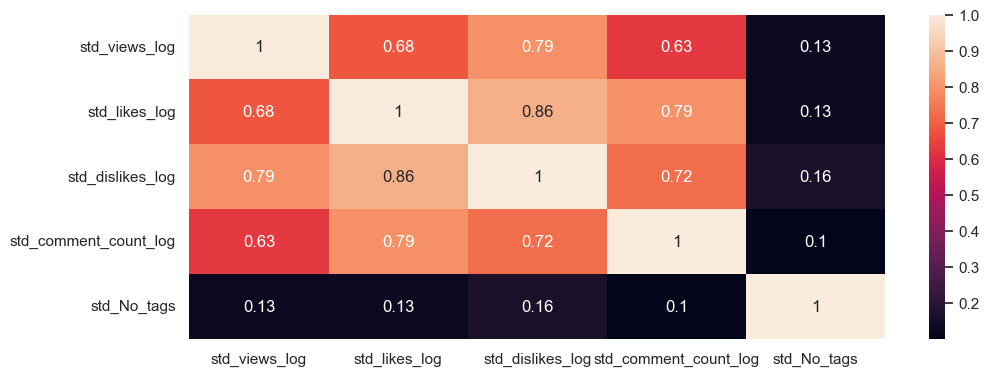

In [27]:
sns.set(rc={'figure.figsize':(10,4)})
sns.heatmap(data_clean[['std_views_log','std_likes_log','std_dislikes_log','std_comment_count_log','std_No_tags']].corr(), annot=True)
#plt.savefig('fig/split train test.png')

In [28]:
X=data_clean[['std_likes_log','std_dislikes_log','std_comment_count_log','std_No_tags']]

In [29]:
X["ratings_disabled"]=data["ratings_disabled"]
X["comments_disabled"]=data["comments_disabled"]

In [30]:
Y=data_clean["std_views_log"]

In [31]:
Data_final=X.copy()

In [32]:
Data_final["target"]=Y.copy()

In [50]:
Data_final.head()

,std_likes_log,std_dislikes_log,std_comment_count_log,std_No_tags,ratings_disabled,comments_disabled,target
12,0.441737,0.279918,0.000000,0.784345,False,True,0.353536
22,0.515826,0.498402,0.482884,0.536741,False,False,0.441346
31,0.509708,0.339930,0.390263,0.383387,False,False,0.403297
37,0.577473,0.440844,0.511304,0.715655,False,False,0.353522
40,0.671623,0.517322,0.545207,0.670927,False,False,0.510718


In [34]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2, random_state=42) #Splitting the data into Train and Test

## Linear regression:

In [35]:
#Fitting simple linear regression to the Training Set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

LinearRegression()

### Predict

In [36]:
pred = regressor.predict(xtest) #Predicting the views

In [37]:
np.exp(pred).round() # inverse log transform

array([1., 2., 2., ..., 1., 2., 2.])

### Evaluation

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_regression(model, pred, xtrain, ytrain, xtest, ytest):
    print("MAE: %.2f" % mean_absolute_error(ytest, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(ytest, pred, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(ytest, pred)) # Explained variance score: 1 is perfect prediction

In [39]:
pred = regressor.predict(xtest)

print('Coefficients: \n', regressor.coef_) # The slope
print('Intercept: \n', regressor.intercept_) # The Intercept

eval_regression(regressor, pred, xtrain, ytrain, xtest,ytest)

Coefficients: 
 [ 0.36063652  0.94493851 -0.23617633  0.00164699  0.4716872  -0.10553523]
Intercept: 
 -0.06028712358426841
MAE: 0.05
RMSE: 0.06
R2 score: 0.78


### Using  statsmodel.formula.api

In [40]:
# Model summary:
# comment_count_log removed (p = 0.895)
formula_string = "target ~ std_likes_log + std_dislikes_log  + ratings_disabled + comments_disabled + std_comment_count_log+std_No_tags"

model = sm.formula.ols(formula = formula_string, data = Data_final)
model_fitted = model.fit()

print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     8769.
Date:                Sun, 07 May 2023   Prob (F-statistic):               0.00
Time:                        22:56:23   Log-Likelihood:                 21703.
No. Observations:               16020   AIC:                        -4.339e+04
Df Residuals:                   16013   BIC:                        -4.334e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Fit Support Vector Regressor Model

In [41]:
from sklearn.svm import SVR

svr = SVR(kernel="linear")
svr.fit(xtrain, ytrain)
pred = svr.predict(xtest)
eval_regression(svr, pred, xtrain, ytrain, xtest, ytest)

MAE: 0.05
RMSE: 0.06
R2 score: 0.77


## Fit MLP

In [42]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
regr = MLPRegressor(random_state=1, max_iter=500).fit(xtrain, ytrain)

In [43]:
regr.score(xtest, ytest)

0.7936906714341287

In [44]:
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(10, 100),
    alpha=0.0001,
    solver = "adam",
    random_state=20565,
    early_stopping=False,
)

In [45]:
nn.fit(xtrain, ytrain)

MLPRegressor(hidden_layer_sizes=(10, 100), random_state=20565)

In [46]:
 nn.score(xtest, ytest)

0.7980615252842471

In [47]:
# VIF analysis

variables = ['std_likes_log','std_dislikes_log','std_comment_count_log',"ratings_disabled","comments_disabled","std_No_tags"]
columns = []
for variable in variables:
    columns.append(X[variable])
baseline = [1 for i in range(Y.count())]
columns.append(baseline)

ck = np.column_stack(columns)

vif = [variance_inflation_factor(ck, i) for i in range(ck.shape[1])]

print("{:>20}: {}".format("Variable", 'VIF'))
for i in range(len(variables)):
    print("{:>20}: {:.1f}".format(variables[i], vif[i]))

            Variable: VIF
       std_likes_log: 7.6
    std_dislikes_log: 4.4
std_comment_count_log: 6.2
    ratings_disabled: 3.0
   comments_disabled: 2.3
         std_No_tags: 1.0


# <span style="color: red;">Conclusion:</span>
- We tried to predict the number of views of the youtube video by using the significant feature and developed a hypothesis, tested it and rejected it.